In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlsettings.settings import load_app_config, get_datafolder_path
from mltools.modelbuilder.supervised import SupervisedDataLoader
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 
np.set_printoptions(precision=4)

pd.set_option('display.width', 200)
pd.set_option('precision', 4)
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
sns.set_style("whitegrid")
pd.options.display.float_format = '{:,.4f}'.format
sns.set()
import logging
logger = logging.getLogger()
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s', datefmt='%d-%b-%y %H:%M:%S')
logger.setLevel(logging.DEBUG)

27-Mar-19 08:36:44 - DEBUG - Loaded backend module://ipykernel.pylab.backend_inline version unknown.
27-Mar-19 08:36:45 - DEBUG - Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [3]:
from sklearn import metrics
from sklearn.metrics import roc_curve
def measure_performance(X, y, clf, show_accuracy=True,show_classification_report=True,
                        show_confusion_matrix=True, show_r2_score=False):
    y_pred = clf.predict(X) 
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format( metrics.accuracy_score(y, y_pred)) )
    if show_classification_report:
        print ("Classification report")
        print (metrics.classification_report(y, y_pred))
    if show_confusion_matrix:
        print("Confusion matrix") 
        print(metrics.confusion_matrix(y, y_pred),)
    if show_r2_score:
        print ("Coefficient of determination:{0:.3f}"
               .format( metrics.r2_score(y, y_pred)))
    return y_pred

from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
def plot_learning_curve(train_sizes, train_scores, validation_scores):
    plt.figure()
    plt.title("Learning Curve")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, validation_scores_mean, 'o-', color="g" ,label="Cross-validation score")
    plt.ylim(max(-3, validation_scores_mean.min() - .1), train_scores_mean.max() + .1)
    plt.legend(loc="best")
    plt.show()

from sklearn.model_selection import validation_curve
def plot_validation_curve(parameter_values, train_scores, validation_scores):
    plt.figure()
    plt.title("Validation Curve")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(parameter_values, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(parameter_values, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    plt.plot(parameter_values, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(parameter_values, validation_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.ylim(validation_scores_mean.min() - .1, train_scores_mean.max() + .1)
    plt.legend(loc="best")
    plt.show()

def plot_roc(X_val,y_val,model):
    fpr, tpr, thresholds = roc_curve(y_val, model.predict_proba(X_val)[:, 1])
    plt.figure()
    plt.plot(fpr, tpr, label="ROC Curve")
    plt.xlabel("FPR")
    plt.ylabel("TPR (recall)")
    plt.title("roc_curve");
    # find threshold closest to zero:
    close_zero = np.argmin(np.abs(thresholds))
    plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)
    plt.legend(loc=4)
    plt.show()

In [4]:
load_app_config()
DATA_DIRECTORY='HRAnalytics'
TRAIN_FILE  = "train.csv"
TEST_FILE  = "test.csv"
RESPONSE = "is_promoted"
input_path = get_datafolder_path()

27-Mar-19 08:36:55 - INFO - Adding D:\DataSource to system path
27-Mar-19 08:36:55 - INFO - Adding D:\MachineLearning to system path


In [5]:
filepath  = pathlib.Path(input_path).joinpath(DATA_DIRECTORY)
train_filepath = filepath.joinpath(TRAIN_FILE)
test_filepath = filepath.joinpath(TEST_FILE)

In [6]:
supervisedloader = SupervisedDataLoader(train_file=train_filepath,test_file=test_filepath,response =RESPONSE) 
train_dataset,test_dataset = supervisedloader.load()
train_y = train_dataset[RESPONSE]

27-Mar-19 08:36:56 - INFO - Loading train_file :D:\DataSource\HRAnalytics\train.csv
27-Mar-19 08:36:57 - INFO - Loading test_file :D:\DataSource\HRAnalytics\test.csv


In [7]:
def get_nullcounts(dataset):
    nullcount_frame = pd.DataFrame({'Feature':dataset.columns.values,
                                    'Missing_Values': dataset.shape[0] - dataset.count().values, })
    nullcount_frame = nullcount_frame[nullcount_frame['Missing_Values']>0].reset_index(drop=True)
    nullcount_frame['Missing_Values%'] = (nullcount_frame['Missing_Values']/dataset.shape[0])*100
    return nullcount_frame

In [8]:
train_dataset.describe()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,"54,808.0000","54,808.0000","54,808.0000","50,684.0000","54,808.0000","54,808.0000","54,808.0000","54,808.0000","54,808.0000"
mean,"39,195.8306",1.2530,34.8039,3.3293,5.8655,0.3520,0.0232,63.3868,0.0852
std,"22,586.5814",0.6093,7.6602,1.2600,4.2651,0.4776,0.1505,13.3716,0.2791
min,1.0000,1.0000,20.0000,1.0000,1.0000,0.0000,0.0000,39.0000,0.0000
25%,"19,669.7500",1.0000,29.0000,3.0000,3.0000,0.0000,0.0000,51.0000,0.0000
50%,"39,225.5000",1.0000,33.0000,3.0000,5.0000,0.0000,0.0000,60.0000,0.0000
75%,"58,730.5000",1.0000,39.0000,4.0000,7.0000,1.0000,0.0000,76.0000,0.0000
max,"78,298.0000",10.0000,60.0000,5.0000,37.0000,1.0000,1.0000,99.0000,1.0000


In [9]:
display(train_dataset.head())
display(test_dataset.head())

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0000,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0000,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0000,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0000,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0000,2,0,0,73,0


,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,8724,Technology,region_26,Bachelor's,m,sourcing,1,24,nan,1,1,0,77
1,74430,HR,region_4,Bachelor's,f,other,1,31,3.0000,5,0,0,51
2,72255,Sales & Marketing,region_13,Bachelor's,m,other,1,31,1.0000,4,0,0,47
3,38562,Procurement,region_2,Bachelor's,f,other,3,31,2.0000,9,0,0,65
4,64486,Finance,region_29,Bachelor's,m,sourcing,1,30,4.0000,7,0,0,61


### EDA 
##### Highly imbalanced dataset

In [10]:
print("% of target variable")
train_dataset['is_promoted'].value_counts()/train_dataset.shape[0]

% of target variable


0   0.9148
1   0.0852
Name: is_promoted, dtype: float64

### Imputing missing values

In [11]:
display(get_nullcounts(train_dataset))
display(get_nullcounts(test_dataset))

,Feature,Missing_Values,Missing_Values%
0,education,2409,4.3953
1,previous_year_rating,4124,7.5244


,Feature,Missing_Values,Missing_Values%
0,education,1034,4.4019
1,previous_year_rating,1812,7.7139


In [12]:
train_rating_by_region_department =train_dataset .groupby(['region','department']) ['previous_year_rating'].median()

In [13]:
train_rating_by_region_department.head()

region    department
region_1  Analytics    4.0000
          Finance      3.0000
          HR           4.5000
          Legal        3.0000
          Operations   4.0000
Name: previous_year_rating, dtype: float64

In [14]:
test_rating_by_region_department = test_dataset.groupby(['region','department'])['previous_year_rating'].median()

In [15]:
def impute_rating(row):
    return train_rating_by_region_department[row['region'],row['department']]

In [16]:
train_dataset['previous_year_rating'].fillna(train_dataset[train_dataset['previous_year_rating'].isnull()].apply(impute_rating, axis=1), inplace=True)

In [17]:
test_dataset['previous_year_rating'].fillna(test_dataset[test_dataset['previous_year_rating'].isnull()].apply(impute_rating, axis=1), inplace=True)

In [18]:
train_education_mode = train_dataset.groupby(['department']).agg({'education':lambda x: x.value_counts(dropna=False).index[0]}).reset_index()

In [19]:
train_education_mode

,department,education
0,Analytics,Bachelor's
1,Finance,Bachelor's
2,HR,Bachelor's
3,Legal,Bachelor's
4,Operations,Bachelor's
5,Procurement,Bachelor's
6,R&D,Bachelor's
7,Sales & Marketing,Bachelor's
8,Technology,Bachelor's


In [20]:
train_dataset['education'].fillna("Bachelor's",inplace=True)
test_dataset['education'].fillna("Bachelor's",inplace=True)

In [21]:
display(get_nullcounts(train_dataset))
display(get_nullcounts(test_dataset))

,Feature,Missing_Values,Missing_Values%


,Feature,Missing_Values,Missing_Values%


In [22]:
full_dataset = pd.concat(objs=[train_dataset,test_dataset],axis=0,sort =True).reset_index(drop=True) 

In [23]:
full_dataset['department'].value_counts() 
full_dataset['education'].value_counts() 

Bachelor's          55690
Master's & above    21429
Below Secondary      1179
Name: education, dtype: int64

In [24]:
department_encoding = {'R&D':1,'Legal':1,'HR':2,'Finance':2,
                       'Analytics':3,'Technology':4,'Procurement':4,
                       'Operations':5,'Sales & Marketing':5}

education_encoding = {"Bachelor's":3,"Master's & above":2,'Below Secondary':1}

gender_encoding = {'f':0,'m':1}
recruitment_channel_encoding = {'other':3,'sourcing':2, 'referred':1}


In [25]:
full_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78298 entries, 0 to 78297
Data columns (total 14 columns):
KPIs_met >80%           78298 non-null int64
age                     78298 non-null int64
avg_training_score      78298 non-null int64
awards_won?             78298 non-null int64
department              78298 non-null object
education               78298 non-null object
employee_id             78298 non-null int64
gender                  78298 non-null object
is_promoted             54808 non-null float64
length_of_service       78298 non-null int64
no_of_trainings         78298 non-null int64
previous_year_rating    78298 non-null float64
recruitment_channel     78298 non-null object
region                  78298 non-null object
dtypes: float64(2), int64(7), object(5)
memory usage: 8.4+ MB


In [26]:
#full_dataset['department'] =full_dataset['department'].map(department_encoding)
#full_dataset['education'] =full_dataset['education'].map(education_encoding)
full_dataset['gender'] =full_dataset['gender'].map(gender_encoding)
full_dataset['recruitment_channel'] =full_dataset['recruitment_channel'].map(recruitment_channel_encoding)
full_dataset['previous_year_rating'] =full_dataset['previous_year_rating'].astype(int)

In [27]:
full_dataset = pd.get_dummies(full_dataset, columns = ["region","department","education"],prefix="d_",drop_first = True)
train_dataset['previous_year_rating'] =train_dataset['previous_year_rating'].astype(int)
full_dataset.rename(columns={'KPIs_met >80%': 'KPIs_met_GT_80', 'awards_won?': 'awards_won'}, inplace=True)

In [28]:
full_dataset.head()

,KPIs_met_GT_80,age,avg_training_score,awards_won,employee_id,gender,is_promoted,length_of_service,no_of_trainings,previous_year_rating,recruitment_channel,d__region_10,d__region_11,d__region_12,d__region_13,d__region_14,d__region_15,d__region_16,d__region_17,d__region_18,d__region_19,d__region_2,d__region_20,d__region_21,d__region_22,d__region_23,d__region_24,d__region_25,d__region_26,d__region_27,d__region_28,d__region_29,d__region_3,d__region_30,d__region_31,d__region_32,d__region_33,d__region_34,d__region_4,d__region_5,d__region_6,d__region_7,d__region_8,d__region_9,d__Finance,d__HR,d__Legal,d__Operations,d__Procurement,d__R&D,d__Sales & Marketing,d__Technology,d__Below Secondary,d__Master's & above
0,1,35,49,0,65438,0,0.0000,8,1,5,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1
1,0,30,60,0,65141,1,0.0000,4,1,5,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,34,50,0,7513,1,0.0000,7,1,3,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,39,50,0,2542,1,0.0000,10,2,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,45,73,0,48945,1,0.0000,2,1,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [29]:
train_dataset =full_dataset[full_dataset['is_promoted'].notnull()]
test_dataset  = full_dataset[full_dataset['is_promoted'].isnull()]
test_dataset_emp =test_dataset['employee_id']
train_y=full_dataset[full_dataset['is_promoted'].notnull()]['is_promoted']

full_dataset.drop(['is_promoted','employee_id','recruitment_channel'],axis =1,inplace=True)
train_dataset.drop(['is_promoted','employee_id','recruitment_channel'],axis =1,inplace=True)
test_dataset.drop(['is_promoted','employee_id','recruitment_channel'],axis =1,inplace=True)


In [30]:
kfold = StratifiedKFold(n_splits=10)
from sklearn.model_selection  import  train_test_split
from sklearn.linear_model  import LogisticRegression
from sklearn.preprocessing import StandardScaler
test_size = 0.25
seed = 2

X_trainmodel, X_val, y_trainmodel, y_val = train_test_split(train_dataset, train_y, test_size=test_size,random_state=seed)

In [31]:
X_trainmodel.head()


,KPIs_met_GT_80,age,avg_training_score,awards_won,gender,length_of_service,no_of_trainings,previous_year_rating,d__region_10,d__region_11,d__region_12,d__region_13,d__region_14,d__region_15,d__region_16,d__region_17,d__region_18,d__region_19,d__region_2,d__region_20,d__region_21,d__region_22,d__region_23,d__region_24,d__region_25,d__region_26,d__region_27,d__region_28,d__region_29,d__region_3,d__region_30,d__region_31,d__region_32,d__region_33,d__region_34,d__region_4,d__region_5,d__region_6,d__region_7,d__region_8,d__region_9,d__Finance,d__HR,d__Legal,d__Operations,d__Procurement,d__R&D,d__Sales & Marketing,d__Technology,d__Below Secondary,d__Master's & above
26984,1,43,68,0,1,5,1,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
668,0,39,68,0,0,5,2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
44692,1,39,85,0,1,7,1,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5678,1,31,62,0,1,4,1,4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
43038,0,44,61,0,0,17,1,3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [32]:
from sklearn.ensemble import ExtraTreesClassifier
# feature extraction

def select_features_by_XTree(X,y):
    model = ExtraTreesClassifier()
    model.fit(X, y.values.ravel())

    selected_features =np.array(model.feature_importances_)
    selected_features_X = pd.DataFrame(X.columns.values, columns=['name'])
    selected_features =selected_features.reshape(selected_features.shape[0],1)

    selected_features_X['model_result'] =selected_features
    selected_features_X =selected_features_X.sort_values(by='model_result',ascending=False)
    return selected_features_X

In [33]:
features_XTree = select_features_by_XTree(X_trainmodel,y_trainmodel)
features = features_XTree[features_XTree['model_result'] > 0.0002]


In [34]:
selected_features = list(features['name'].values)
",".join(selected_features)

"avg_training_score,age,length_of_service,previous_year_rating,KPIs_met_GT_80,no_of_trainings,awards_won,gender,d__Operations,d__Procurement,d__Master's & above,d__Technology,d__Sales & Marketing,d__region_2,d__Finance,d__region_7,d__region_13,d__region_26,d__region_31,d__region_22,d__region_4,d__region_27,d__region_15,d__region_17,d__HR,d__region_28,d__region_23,d__region_16,d__R&D,d__region_25,d__region_20,d__region_11,d__region_14,d__region_30,d__Below Secondary,d__region_10,d__region_8,d__Legal,d__region_19,d__region_29,d__region_3,d__region_32,d__region_5,d__region_24,d__region_12,d__region_6,d__region_21,d__region_33,d__region_9,d__region_34"

In [35]:
from yellowbrick.features import Rank1D, Rank2D 
from yellowbrick.features import RadViz

In [36]:
#features =X_trainmodel.columns.values

In [37]:
#X_trainmodel = X_trainmodel[selected_features]
#X_val =X_val[selected_features]
#test_dataset = test_dataset[selected_features]


27-Mar-19 08:37:28 - DEBUG - update_title_pos
27-Mar-19 08:37:28 - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to Arial ('C:\\WINDOWS\\Fonts\\arial.ttf') with score of 0.050000.
27-Mar-19 08:37:28 - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to Arial ('C:\\WINDOWS\\Fonts\\arial.ttf') with score of 0.050000.
27-Mar-19 08:37:28 - DEBUG - update_title_pos
27-Mar-19 08:37:29 - DEBUG - update_title_pos
27-Mar-19 08:37:29 - DEBUG - update_title_pos


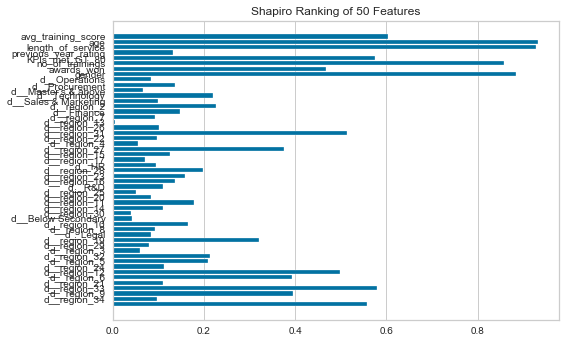

In [38]:
visualizer = Rank1D(features=selected_features, algorithm='shapiro')
visualizer.fit(X_trainmodel, y_trainmodel)                # Fit the data to the visualizer
visualizer.transform(X_trainmodel)             # Transform the data
visualizer.poof()     

27-Mar-19 08:37:30 - DEBUG - locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x00000244B65F8358>
27-Mar-19 08:37:30 - DEBUG - Using auto colorbar locator on colorbar
27-Mar-19 08:37:30 - DEBUG - locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x00000244B65F8358>
27-Mar-19 08:37:30 - DEBUG - Setting pcolormesh
27-Mar-19 08:37:31 - DEBUG - update_title_pos
27-Mar-19 08:37:31 - DEBUG - update_title_pos
27-Mar-19 08:37:31 - DEBUG - update_title_pos
27-Mar-19 08:37:32 - DEBUG - update_title_pos
27-Mar-19 08:37:32 - DEBUG - update_title_pos
27-Mar-19 08:37:32 - DEBUG - update_title_pos
27-Mar-19 08:37:32 - DEBUG - update_title_pos
27-Mar-19 08:37:33 - DEBUG - update_title_pos


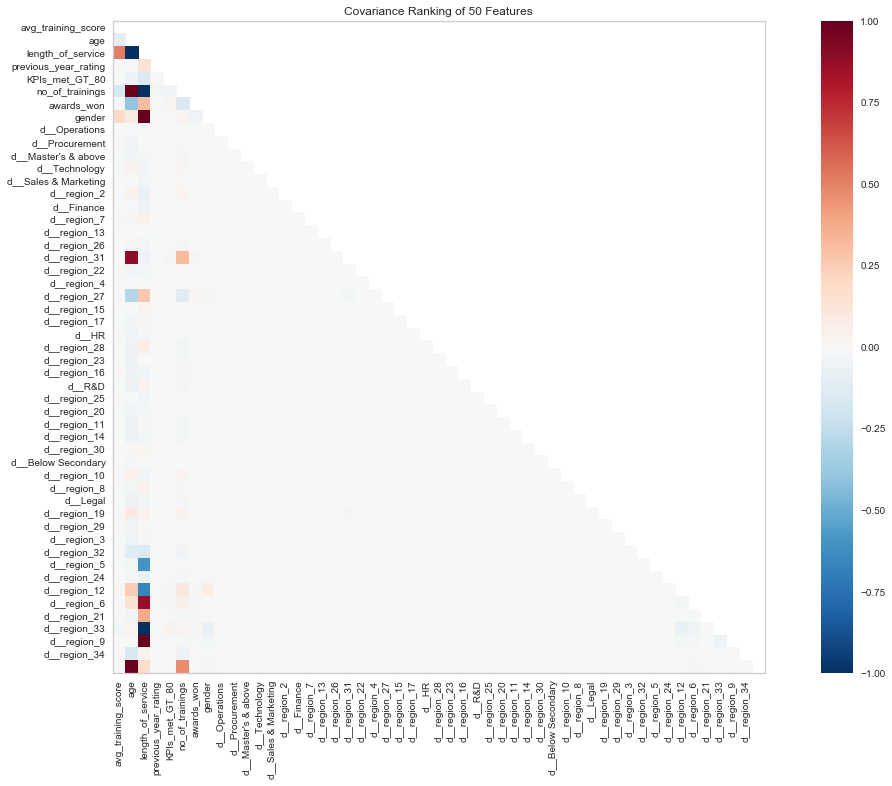

In [39]:
visualizer = Rank2D(features=selected_features, algorithm='covariance')
plt.figure(figsize=(20,12))
visualizer.fit(X_trainmodel, y_trainmodel)                # Fit the data to the visualizer
visualizer.transform(X_trainmodel)             # Transform the data
visualizer.poof()  

In [40]:
from sklearn.linear_model  import LogisticRegression
logrmodel = LogisticRegression()
logrmodel.fit(X_trainmodel , y_trainmodel.values.ravel())
result = logrmodel.score(X_val, y_val)
print ("Accuracy: {0:.3f}".format(result*100.0))

Accuracy: 93.096


In [41]:
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import make_pipeline

In [42]:
SEED = 222
np.random.seed(SEED)

In [43]:
from sklearn import metrics
from sklearn.metrics import roc_curve
def measure_performance(X, y, clf, show_accuracy=True,show_classification_report=True,
                        show_confusion_matrix=True, show_r2_score=False):
    y_pred = clf.predict(X) 
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format( metrics.accuracy_score(y, y_pred)) )
    if show_classification_report:
        print ("Classification report")
        print (metrics.classification_report(y, y_pred))
    if show_confusion_matrix:
        print("Confusion matrix") 
        print(metrics.confusion_matrix(y, y_pred),)
    if show_r2_score:
        print ("Coefficient of determination:{0:.3f}"
               .format( metrics.r2_score(y, y_pred)))
    return y_pred

from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
def plot_learning_curve(train_sizes, train_scores, validation_scores):
    plt.figure()
    plt.title("Learning Curve")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, validation_scores_mean, 'o-', color="g" ,label="Cross-validation score")
    plt.ylim(max(-3, validation_scores_mean.min() - .1), train_scores_mean.max() + .1)
    plt.legend(loc="best")
    plt.show()

from sklearn.model_selection import validation_curve
def plot_validation_curve(parameter_values, train_scores, validation_scores):
    plt.figure()
    plt.title("Validation Curve")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(parameter_values, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(parameter_values, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    plt.plot(parameter_values, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(parameter_values, validation_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.ylim(validation_scores_mean.min() - .1, train_scores_mean.max() + .1)
    plt.legend(loc="best")
    plt.show()

def plot_roc(X_val,y_val,model):
    fpr, tpr, thresholds = roc_curve(y_val, model.predict_proba(X_val)[:, 1])
    plt.figure()
    plt.plot(fpr, tpr, label="ROC Curve")
    plt.xlabel("FPR")
    plt.ylabel("TPR (recall)")
    plt.title("roc_curve");
    # find threshold closest to zero:
    close_zero = np.argmin(np.abs(thresholds))
    plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)
    plt.legend(loc=4)
    plt.show()

def test_classifier(model,X,y,cv):
    clf = model.fit(X,y.values.ravel())
    result = clf.score(X,y.values)
    print ("Accuracy: {0:.3f}".format(result*100.0))

    train_sizes, train_scores, validation_scores = learning_curve(clf, X,y.values.ravel(),cv=cv)
    plot_learning_curve(train_sizes, train_scores, validation_scores)
    return clf,result

In [44]:
from xgboost.sklearn import XGBClassifier

xgbclf= XGBClassifier(n_estimators=100, silent=False)
xgbclf.fit(X_trainmodel ,y_trainmodel.values.ravel())

warnings.filterwarnings("ignore", category=DeprecationWarning) 

#best_model ,result = test_classifier(xgbclf,X_trainmodel,y_trainmodel,kfold)
print(xgbclf)


[08:37:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:37:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[08:37:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:37:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:37:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:37:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:37:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:37:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:37:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[08:37:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:37:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[08:37:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:37:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:37:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[08:37:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:37:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:37:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:37:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_de

27-Mar-19 08:37:46 - DEBUG - update_title_pos
27-Mar-19 08:37:46 - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=11.0 to Arial ('C:\\WINDOWS\\Fonts\\arial.ttf') with score of 0.050000.
27-Mar-19 08:37:46 - DEBUG - update_title_pos
27-Mar-19 08:37:47 - DEBUG - update_title_pos
27-Mar-19 08:37:47 - DEBUG - update_title_pos


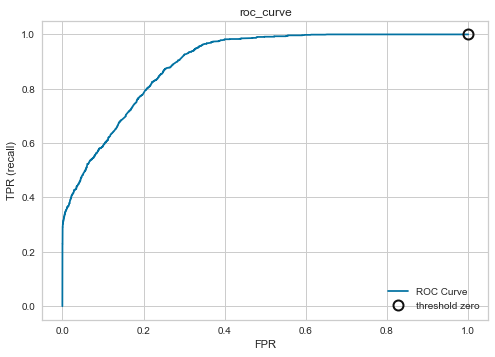

In [45]:
plot_roc(X_val,y_val,xgbclf)

In [46]:
import xgboost as xgb

In [47]:
from sklearn.metrics import f1_score
def calc_f1_score(predictions, y_test):
    labels = y_test.get_label()
    y_bin = [1. if y_cont > 0.5 else 0. for y_cont in predictions]
    return 'f1',f1_score(labels,y_bin)

In [48]:
params = {"objective": "multi:softmax",
          'num_class': 2,
          "booster" : "gbtree",
          'learning_rate': 0.1,
          "max_depth": 4,
          "subsample": 0.8,
          'colsample_bylevel': 0.8,
          'gamma': 0.4,
          'min_child_weight': 7,
          "silent": 1,
          'scale_pos_weight':3
          }

num_boost_round =200

In [49]:
print("Train a XGBoost model")
dtrain = xgb.DMatrix(X_trainmodel, y_trainmodel)
dvalid = xgb.DMatrix(X_val, y_val)

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, watchlist,
                feval=calc_f1_score, maximize=True, early_stopping_rounds=50, verbose_eval=True)

Train a XGBoost model
[0]	train-merror:0.074734	eval-merror:0.075609	train-f1:0.256174	eval-f1:0.258941
Multiple eval metrics have been passed: 'eval-f1' will be used for early stopping.

Will train until eval-f1 hasn't improved in 50 rounds.
[1]	train-merror:0.07488	eval-merror:0.075682	train-f1:0.253275	eval-f1:0.257695
[2]	train-merror:0.074515	eval-merror:0.075244	train-f1:0.25925	eval-f1:0.265146
[3]	train-merror:0.074636	eval-merror:0.075172	train-f1:0.256783	eval-f1:0.265335
[4]	train-merror:0.074515	eval-merror:0.076412	train-f1:0.239006	eval-f1:0.225019
[5]	train-merror:0.074369	eval-merror:0.076193	train-f1:0.242003	eval-f1:0.228951
[6]	train-merror:0.074174	eval-merror:0.076047	train-f1:0.240976	eval-f1:0.225854
[7]	train-merror:0.074052	eval-merror:0.075828	train-f1:0.242409	eval-f1:0.227509
[8]	train-merror:0.073906	eval-merror:0.075755	train-f1:0.24503	eval-f1:0.231111
[9]	train-merror:0.073931	eval-merror:0.075755	train-f1:0.243088	eval-f1:0.227679
[10]	train-merror:0.07

[98]	train-merror:0.059018	eval-merror:0.059845	train-f1:0.474437	eval-f1:0.477041
[99]	train-merror:0.058994	eval-merror:0.059772	train-f1:0.474995	eval-f1:0.478011
[100]	train-merror:0.059018	eval-merror:0.059772	train-f1:0.474664	eval-f1:0.478011
[101]	train-merror:0.058969	eval-merror:0.059845	train-f1:0.475325	eval-f1:0.477041
[102]	train-merror:0.058969	eval-merror:0.059699	train-f1:0.475325	eval-f1:0.478981
[103]	train-merror:0.058945	eval-merror:0.059772	train-f1:0.475655	eval-f1:0.478676
[104]	train-merror:0.058921	eval-merror:0.059699	train-f1:0.475758	eval-f1:0.479644
[105]	train-merror:0.058945	eval-merror:0.059699	train-f1:0.475655	eval-f1:0.479644
[106]	train-merror:0.058872	eval-merror:0.059553	train-f1:0.47687	eval-f1:0.481576
[107]	train-merror:0.058848	eval-merror:0.059553	train-f1:0.477199	eval-f1:0.481576
[108]	train-merror:0.058848	eval-merror:0.059553	train-f1:0.477199	eval-f1:0.481576
[109]	train-merror:0.058848	eval-merror:0.05948	train-f1:0.477199	eval-f1:0.482

[196]	train-merror:0.056439	eval-merror:0.058313	train-f1:0.510342	eval-f1:0.500937
[197]	train-merror:0.056439	eval-merror:0.058313	train-f1:0.510342	eval-f1:0.500937
[198]	train-merror:0.056415	eval-merror:0.058386	train-f1:0.510656	eval-f1:0.500624
[199]	train-merror:0.056415	eval-merror:0.058459	train-f1:0.510656	eval-f1:0.500312


In [50]:
test_y  =gbm.predict(xgb.DMatrix(test_dataset))

In [51]:
submission =pd.DataFrame({'employee_id':test_dataset_emp.values ,'is_promoted':test_y}) 
#submission['Loan_Status'].replace(0, 'N',inplace=True)
#submission['Loan_Status'].replace(1, 'Y',inplace=True)
import datetime
FORMAT = '%Y%m%d%H%M%S'
timestamp=datetime.datetime.now().strftime(FORMAT)
filename ="HR_Analytics_XgBoost"+timestamp+"_out.csv"
#submission.to_csv(filename,index=False)

In [52]:
submission.to_csv(filename,index=False)

In [53]:
# from yellowbrick.features import RFECV
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import StratifiedKFold
# cv = StratifiedKFold(3)
# oz = RFECV(RandomForestClassifier(), cv=cv, scoring='f1_weighted')

# oz.fit(X_trainmodel, y_trainmodel)
# oz.poof()